# Alright this is for all of the marbles

# Imports

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
import sys
from os.path import join
import os

In [11]:
# Import Internal Modules 
sys.path.append(os.path.abspath('..'))

from utils_basic import SPECTROGRAM_DIR as indir
from utils_plot import plot_geo_total_psd_to_bin_array_spectrogram, save_figure

print("initializing file")

initializing file


# Load In Some Bin Specs

In [12]:
window = 72
threshold = 345
station = 'A01'

In [13]:
bin_specs_arr = np.load(f'/fp/projects01/ec332/data/altered_spectrograms/bin_spec_no_res_{window}_{threshold}.npz')['spectrograms']

In [14]:
full_power_spectrograms_path = f'/fp/projects01/ec332/data/altered_spectrograms/power_spec_{station}_{window}_{threshold}.npz'
full_power_data = np.load(full_power_spectrograms_path, allow_pickle=True)
full_power_spectrograms = full_power_data['spectrograms']

In [33]:
full_power_spectrograms.

(2410,)

In [73]:
spectrogram_index = 1100
power_spec = full_power_spectrograms[spectrogram_index]
binary_image = bin_specs_arr[spectrogram_index] 

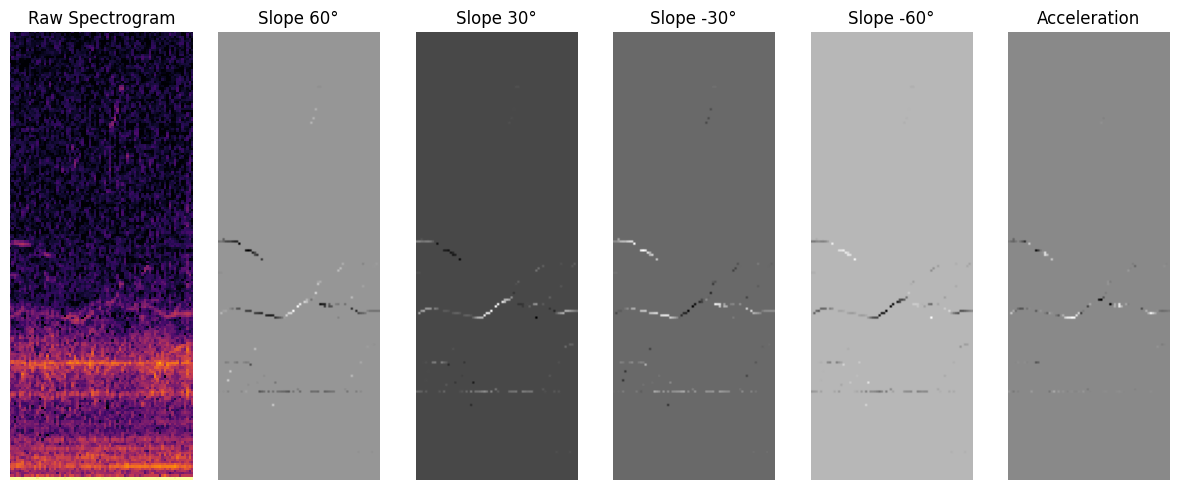

In [78]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math

def create_slope_filter(angle, size=13):
    """
    Create a slope filter of a given angle (in degrees) for a binary image.
    """
    filter_tensor = np.zeros((size, size))
    
    # Calculate slope gradient
    angle_rad = np.deg2rad(angle)
    if angle < 0:
        angle = 180 + angle
    
    for i in range(size):
        for j in range(size):
            x = i - size // 2
            y = j - size // 2
            if x == 0 and y == 0:
                filter_tensor[i, j] = 100
            else:
                # Calculate the angle in degrees
                angle_radians = math.atan2(y, x)
                deg = math.degrees(angle_radians)
                # Calculate the slope value based on angular difference
                filter_tensor[i, j] = (45 - np.abs(90 - min(np.abs(angle - deg), np.abs(angle + 180 - deg), np.abs(angle - 180 - deg)))) / 45
    return torch.tensor(filter_tensor, dtype=torch.float32)

def create_horizontal_gradient_filter(size=3):
    """
    Create a horizontal gradient filter with negative values on the left 
    and positive values on the right, constant across height.
    """
    # Create a linear gradient from -1 to 1
    gradient = np.linspace(-1, 1, size)  # Change this range as needed to control the gradient
    # Repeat this gradient across all rows to form a 2D filter
    filter_tensor = np.tile(gradient, (size, 1))  # Shape: (size, size)
    
    return torch.tensor(filter_tensor, dtype=torch.float32)

def create_opposite_horizontal_gradient_filter(size=3):
    """
    Create a horizontal gradient filter with positive values on the left 
    and negative values on the right, constant across height.
    """
    # Create a linear gradient from 1 to -1
    gradient = np.linspace(1, -1, size)  # Reverse the range for the opposite effect
    # Repeat this gradient across all rows to form a 2D filter
    filter_tensor = np.tile(gradient, (size, 1))  # Shape: (size, size)
    
    return torch.tensor(filter_tensor, dtype=torch.float32)


# Convert to a PyTorch tensor and add batch and channel dimensions
input_tensor = torch.tensor(binary_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 200, 200)

# Create slope filters for the desired angles: -60, -45, -30, 0, 30, 45, 60 degrees
angles = [-60, -45, -30, 0, 30, 45, 60]
filters = [create_slope_filter(angle) for angle in angles]

# Stack all filters into a single tensor
conv_filters = torch.stack([f.unsqueeze(0) for f in filters], dim=0)  # Shape: (7, 1, 5, 5)

# Define a Conv2d layer with these custom filters
conv_layer = nn.Conv2d(in_channels=1, out_channels=len(angles), kernel_size=13, stride=1, padding=6, bias=False)  # Adjust padding to maintain dimensions
conv_layer.weight = nn.Parameter(conv_filters)

# Apply the convolution to the input tensor
output_tensor_mask = conv_layer(input_tensor)
output_tensor = conv_layer(input_tensor)

# Apply the threshold and subtract the central weight of the filter
output_tensor = output_tensor - 100
output_tensor[output_tensor_mask < 50] = 0

# Weight by the tangent of the slope and sum
combined_image = torch.zeros_like(output_tensor[0, 0])
for i, angle in enumerate(angles):
    # Calculate the tangent of the angle
    weight = np.tan(np.deg2rad(angle))
    # Add weighted output to the combined image
    combined_image += weight * output_tensor[0, i]

# Apply the acceleration and deceleration filters to the combined image
acceleration_filter = create_horizontal_gradient_filter(5)
deceleration_filter = create_opposite_horizontal_gradient_filter(5)

# Convert combined image to 4D tensor for convolution
combined_tensor = combined_image.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, H, W)


# Define convolutional layers for the acceleration and deceleration filters
accel_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=13, stride=1, padding=2, bias=False)
decel_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=13, stride=1, padding=2, bias=False)

# Set the weights of these layers
accel_layer.weight = nn.Parameter(acceleration_filter.unsqueeze(0).unsqueeze(0))  # Shape: (1, 1, 13, 13)
decel_layer.weight = nn.Parameter(deceleration_filter.unsqueeze(0).unsqueeze(0))  # Shape: (1, 1, 13, 13)

# Apply the filters to the combined image
acceleration_image = accel_layer(combined_tensor).squeeze().detach().numpy()
deceleration_image = decel_layer(combined_tensor).squeeze().detach().numpy()

# Filter for white pixels
acceleration_image[output_tensor_mask[0][0] < 50] = 0
deceleration_image[output_tensor_mask[0][0] < 50] = 0

# Convert the output tensor to a NumPy array for plotting
output_images = output_tensor.squeeze().detach().numpy()
combined_image_np = combined_image.detach().numpy()

# Plot the individual slopes, the combined image, and the acceleration/deceleration images
fig, axes = plt.subplots(1, len(angles)//2 + 3, figsize=(12, 5))  # Include combined, acceleration, and deceleration

# Plot individual slope images
titles = ['60°', '45°', '30°', '0°', '-30°', '-45°', '-60°']
for i in [0,1,2,3]:
    axes[i+1].imshow(output_images[i*2], cmap='gray',origin = 'lower')
    axes[i+1].set_title(f'Slope {titles[i*2]}')
    axes[i+1].axis('off')

# # Plot combined image
# axes[len(angles)//2+1].imshow(combined_image_np, cmap='gray')
# axes[len(angles)//2+1].set_title('Combined Image')
# axes[len(angles)//2+1].axis('off')

# Plot Full Power Image
power_spec.plot(ax=axes[0], min_db=-20, max_db=20)
axes[0].axis('off')
axes[0].set_title('Raw Spectrogram')

# Plot acceleration and deceleration images
axes[len(angles)//2 + 2].imshow(deceleration_image, cmap='gray',origin='lower')
axes[len(angles)//2 + 2].set_title('Acceleration')
axes[len(angles)//2 + 2].axis('off')

# axes[len(angles) + 2].imshow(deceleration_image, cmap='gray')
# axes[len(angles) + 2].set_title('Deceleration')
# axes[len(angles) + 2].axis('off')

plt.tight_layout()
# plt.savefig('example_spectrogram_2.png', dpi=600, bbox_inches='tight')
plt.show()


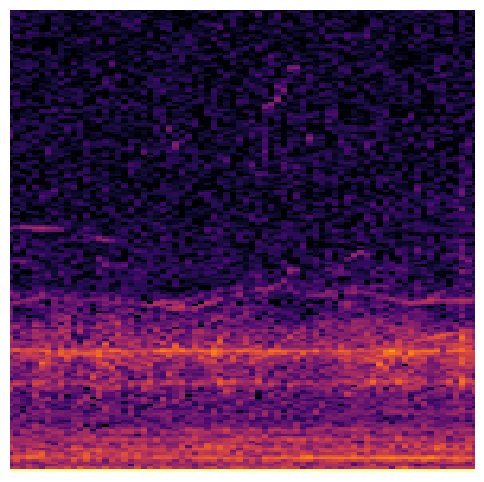

In [88]:
# plt.savefig('example_spectrogram_2.png', dpi=600, bbox_inches='tight')
fig, axes = plt.subplots(1, 1, figsize=(6, 6))

power_spec.plot(ax=axes, min_db=-20, max_db=20)
axes.axis('off')
#plt.show()
plt.savefig('example_spectrogram_3.png', dpi=600, bbox_inches='tight')

In [ ]:
axes.imshow(binary_image, cmap='gray',origin='lower')
binary_image

(9, 200, 72)
(9, 200)


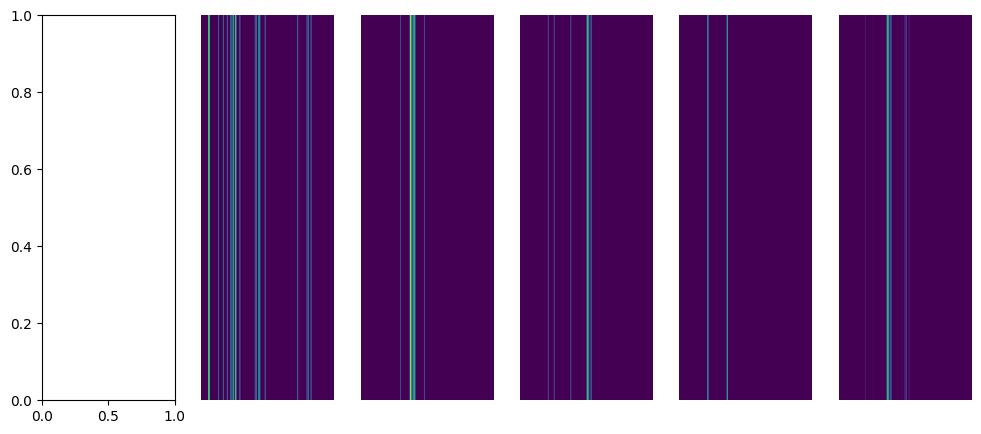

In [117]:
def condense_image_by_frequency_bins(image, num_bins):
    """
    Condense an image by summing rows into the specified number of frequency bins.
    """
    # Ensure the input is a PyTorch tensor
    if isinstance(image, np.ndarray):
        image = torch.from_numpy(image)

    height = image.size(0)  # Use `.size()` for PyTorch tensors
    bin_size = height // num_bins  # Determine the size of each bin
    condensed_image = []
    for i in range(num_bins):
        # Calculate the start and end indices for the current bin
        start_idx = i * bin_size
        end_idx = (i + 1) * bin_size if i < num_bins - 1 else height  # Include any leftover rows in the last bin
        # Sum the rows in the current bin using torch.sum
        bin_sum = torch.sum(image[start_idx:end_idx, :], dim=0)  # Use `dim` instead of `axis`
        condensed_image.append(bin_sum)
    
    # Use torch.stack to combine into a tensor and sum along the columns
    condensed_image = torch.stack(condensed_image, dim=0)
    return torch.sum(condensed_image, dim=1)

connect_filter = torch.tensor([[[[1,1,1,],
                                [1,10,1],
                                [1,1,1]]]], dtype=torch.float32)

connect_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size = 3, stride = 1, padding = 1, bias=False)
connect_layer.weight = nn.Parameter(connect_filter)
input_tensor = torch.tensor(binary_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, H, W)

# Apply the connectivity filter to the input tensor
connect_tensor = connect_layer(input_tensor)
connect_tensor_mask = connect_layer(input_tensor)

# Apply the threshold to the connectivity filter
connect_tensor[connect_tensor_mask > 10] = 1
connect_tensor[connect_tensor_mask <= 10] = 0

# Apply the convolution to the input tensor
output_tensor_mask = conv_layer(input_tensor)
output_tensor = conv_layer(connect_tensor)

# Apply the threshold and subtract the central weight of the filter
output_tensor = output_tensor - 100
output_tensor[output_tensor_mask < 50] = 0
        
# Fast Make Output Tensor Sharper
max_indices = torch.argmax(output_tensor[0], dim=0)
output_images_list = torch.zeros_like(output_tensor)
output_images_list.scatter_(1, max_indices.unsqueeze(0).unsqueeze(0), 1)

expanded_mask = output_tensor_mask
output_images_list[expanded_mask.expand_as(output_images_list) < 50] = 0

# Weight by the tangent of the slope and sum
combined_image = torch.zeros_like(output_tensor[0, 0])
for i, angle in enumerate(angles):
    # Calculate the tangent of the angle
    weight = np.tan(np.deg2rad(angle))
    # Add weighted output to the combined image
    combined_image += weight * output_tensor[0, i]
    # Add individual slope images to the list
# Convert combined image to 4D tensor for convolution
combined_tensor = combined_image.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, H, W)

# Apply the filters to the combined image
acceleration_image = accel_layer(combined_tensor).squeeze().detach().numpy()/100
deceleration_image = decel_layer(combined_tensor).squeeze().detach().numpy()/100

# Filter for white pixels
acceleration_image[output_tensor_mask[0][0] < 50] = 0
deceleration_image[output_tensor_mask[0][0] < 50] = 0

# Apply Relu:
acceleration_image[acceleration_image < 0] = 0
deceleration_image[deceleration_image < 0] = 0

# Add acceleration and deceleration images to the list
output_images_list = list(output_images_list[0])
output_images_list.append(acceleration_image)
output_images_list.append(deceleration_image)
print(np.array(output_images_list).shape)

# Condense each image by summing into frequency bins
condensed_images_list = [condense_image_by_frequency_bins(img, 200) for img in output_images_list]
print(np.array(condensed_images_list).shape)
fig, axes = plt.subplots(1, len(angles)//2 + 3, figsize=(12, 5)) 
for i in [0,1,2,3,4]:
    axes[i+1].imshow([condensed_images_list[i*2]],aspect='auto', cmap='viridis')
    axes[i+1].axis('off')
    
# Store the condensed images for the current spectrogram
# all_condensed_images.append(condensed_images_list)